In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn import datasets
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def brute_force_removal(original_linear_regressor, X_train, y_train, x_test, max_size):
    # Initialize variables to keep track of the best subset and loss difference for parameter changes
    best_subset_fix_test = np.full((max_size), None)

    original_score = x_test.dot(original_linear_regressor.coef_) + original_linear_regressor.intercept_

    # Loop over different subset sizes from 1 to max_size
    for subset_size in range(1, max_size + 1):
        # Generate all combinations of subsets of the current size
        subset_combinations = combinations(range(X_train.shape[0]), subset_size)

        max_score_difference = -float("inf")

        for subset_to_remove in subset_combinations:
            # Create a new training set without the selected data points
            reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
            reduced_y_train = np.delete(y_train, subset_to_remove, axis=0)

            # Train a Linear Regression model on the reduced training set
            reduced_linear_regressor = LinearRegression()
            reduced_linear_regressor.fit(reduced_X_train, reduced_y_train)

            # Make inference
            reduced_score = x_test.dot(reduced_linear_regressor.coef_) + reduced_linear_regressor.intercept_

            # Calculate the difference in loss
            score_difference = reduced_score - original_score

            # Update if the current subset induces the minimum change in loss
            if score_difference > max_score_difference:
                max_score_difference = score_difference
                best_subset_fix_test[subset_size - 1] = subset_to_remove

        print(f"Best subset of size {subset_size}: {best_subset_fix_test[subset_size - 1]}")

    return best_subset_fix_test

In [19]:
def influence(X_train, y_train, coef, x_test, leverage=False):
	n_samples = X_train.shape[0]
	influences = np.zeros(n_samples)
	X = np.hstack((np.ones((n_samples, 1)), X_train))  # Add a column of ones for the intercept

	# Fixed test point with intercept feature
	fixed_test_point = np.hstack((1, x_test))

	N = np.dot(X.T, X)
	N_inv = np.linalg.inv(N)

	influences = np.dot(np.dot(fixed_test_point, N_inv), X.T * (np.dot(X, coef) - y_train))

	if leverage:
		H = X.dot(N_inv).dot(X.T)
		# Calculate the influence using the provided formula
		influences = influences / (1 - np.diagonal(H))

		print(f"Largest off-diagonal entry of H: {H[~np.eye(*H.shape, dtype=bool)].max()}")

		# Plot the leverage scores empirical distribution
		plt.figure(figsize=(12, 6))  # Set the figure size to accommodate both plots side by side
		plt.subplot(1, 2, 1)  # Create the first subplot
		plt.hist(np.diagonal(H), bins=30, color='blue', alpha=0.7)  # Adjust appearance as needed
		plt.xlabel('Leverage Score')
		plt.ylabel('Frequency')
		plt.title('Leverage Scores Empirical Distribution')

		# Create the second subplot for off-diagonal entries of H
		plt.subplot(1, 2, 2)
		off_diagonal_H = H - np.diag(np.diagonal(H))  # Extract off-diagonal entries
		plt.hist(off_diagonal_H[~np.eye(*H.shape, dtype=bool)], bins=30, color='green', alpha=0.7)  # Adjust appearance as needed
		plt.xlabel('Off-Diagonal Entry of H')
		plt.ylabel('Frequency')
		plt.title('Off-Diagonal Entries of H Empirical Distribution')

		plt.tight_layout()  # Adjust spacing between subplots for a clean layout
		plt.show()  # Display both plots side-by-side

	return influences

In [14]:
def linear_regression(X, y, n, max_size):
	print(f"Dataset size: {X.shape[0]} samples, {X.shape[1]} features")

	test_size = 1 - n / X.shape[0]

	# Split the data into training and testing sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

	# Create a Linear Regression model
	linear_regressor = LinearRegression()

	# Train the linear regressor on the training data
	linear_regressor.fit(X_train, y_train)

	# Make predictions on the test data
	y_pred = linear_regressor.predict(X_test)

	# Calculate Mean Squared Error (MSE)
	mse = np.mean((y_pred - y_test) ** 2)
	print(f"Mean Squared Error: {mse:.4f}")

	fixed_test_point_index = 0
	fixed_test_point = X_test[fixed_test_point_index]

	best_subset = brute_force_removal(linear_regressor, X_train, y_train, fixed_test_point, max_size)

	# Create the logistic regression model and fit it
	coefficients = np.hstack((linear_regressor.intercept_, linear_regressor.coef_))


	print("Without leverage")
	influences = influence(X_train, y_train, coefficients, fixed_test_point)
	top_indices = np.argsort(influences)[-(max_size+3):][::-1]
	print(f"Top {max_size+3} Influential Data Points Estimate: {top_indices}")


	print("With leverage")
	influences = influence(X_train, y_train, coefficients, fixed_test_point, leverage=True)
	top_indices = np.argsort(influences)[-(max_size+3):][::-1]
	print(f"Top {max_size+3} Influential Data Points Estimate: {top_indices}")


Adding 1 random Gaussian features

Dataset size: 442 samples, 10 features
Mean Squared Error: 3423.4462
Best subset of size 1: (10,)
Best subset of size 2: (10, 69)
Best subset of size 3: (10, 12, 69)
Best subset of size 4: (10, 12, 40, 69)
Without leverage
Top 7 Influential Data Points Estimate: [10 69 12 40 75 65 63]
With leverage
Largest off-diagonal entry of H: 0.27494950621582


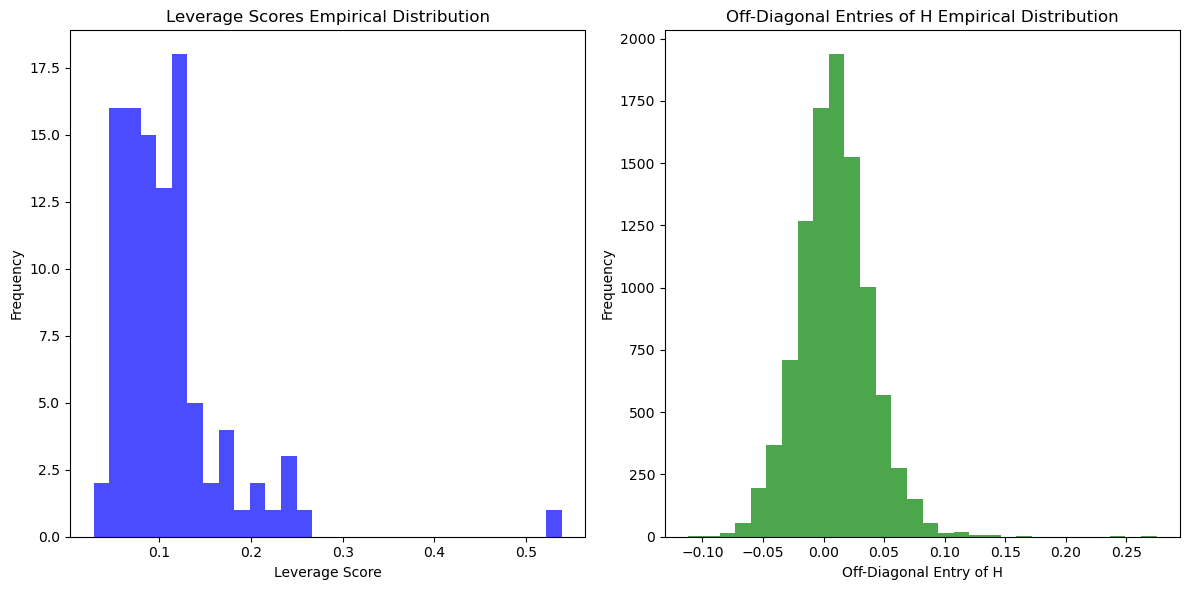

Top 7 Influential Data Points Estimate: [10 69 12 65 75 40 63]

Adding 2 random Gaussian features

Dataset size: 442 samples, 55 features
Mean Squared Error: 13341.3205
Best subset of size 1: (13,)
Best subset of size 2: (13, 68)
Best subset of size 3: (0, 13, 68)
Best subset of size 4: (0, 4, 62, 84)
Without leverage
Top 7 Influential Data Points Estimate: [ 0 84 25 10  7 99 13]
With leverage
Largest off-diagonal entry of H: 0.2539926341902671


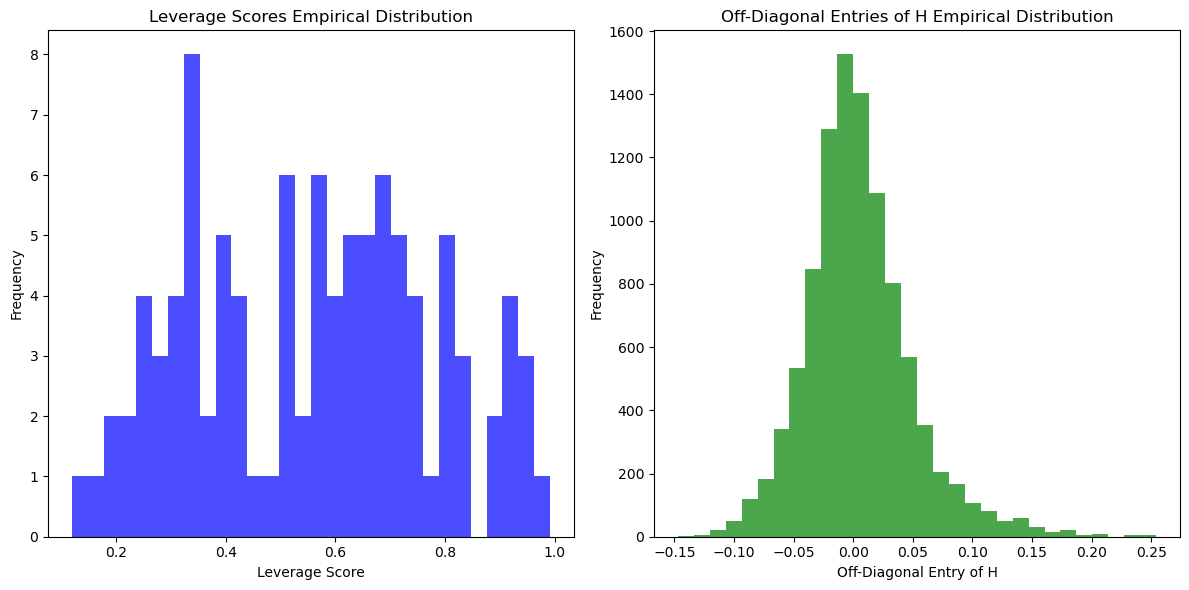

Top 7 Influential Data Points Estimate: [13 25 68  0  4 84 99]


In [18]:
X, y = datasets.load_diabetes(return_X_y=True)

X_interact = X.copy()

for i in range(2):
	# Add features of interacting terms between the original features
	poly = PolynomialFeatures(degree=i+1, interaction_only=True, include_bias=False)
	X_interact = poly.fit_transform(X_interact)

	linear_regression(X_interact, y, 100, 4)


Adding 1 random Gaussian features

Dataset size: 20640 samples, 8 features
Mean Squared Error: 20.4643
Best subset of size 1: (75,)
Best subset of size 2: (75, 84)
Best subset of size 3: (37, 75, 84)
Best subset of size 4: (23, 37, 75, 84)
Without leverage
Top 7 Influential Data Points Estimate: [75 84 67 37 23 25 44]
With leverage
Largest off-diagonal entry of H: 0.24378851493878617


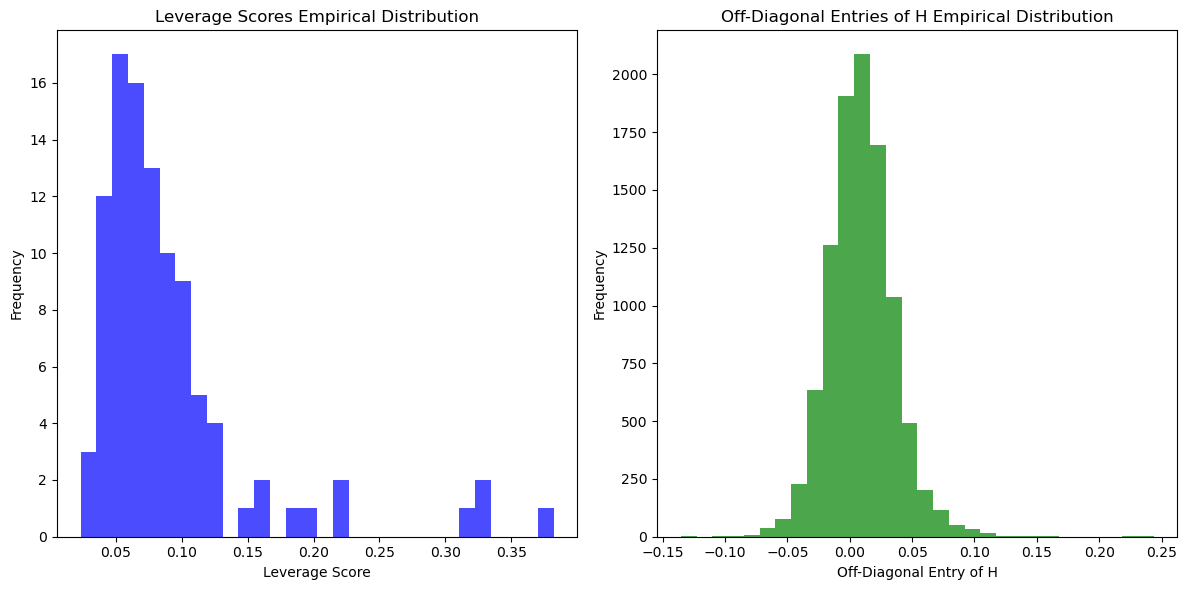

Top 7 Influential Data Points Estimate: [75 84 67 23 37 25 44]

Adding 2 random Gaussian features

Dataset size: 20640 samples, 36 features
Mean Squared Error: 4526.1771
Best subset of size 1: (62,)
Best subset of size 2: (16, 62)
Best subset of size 3: (16, 62, 79)
Best subset of size 4: (16, 17, 62, 79)
Without leverage
Top 7 Influential Data Points Estimate: [62 79 16 53 60  1 91]
With leverage
Largest off-diagonal entry of H: 0.26920711188213187


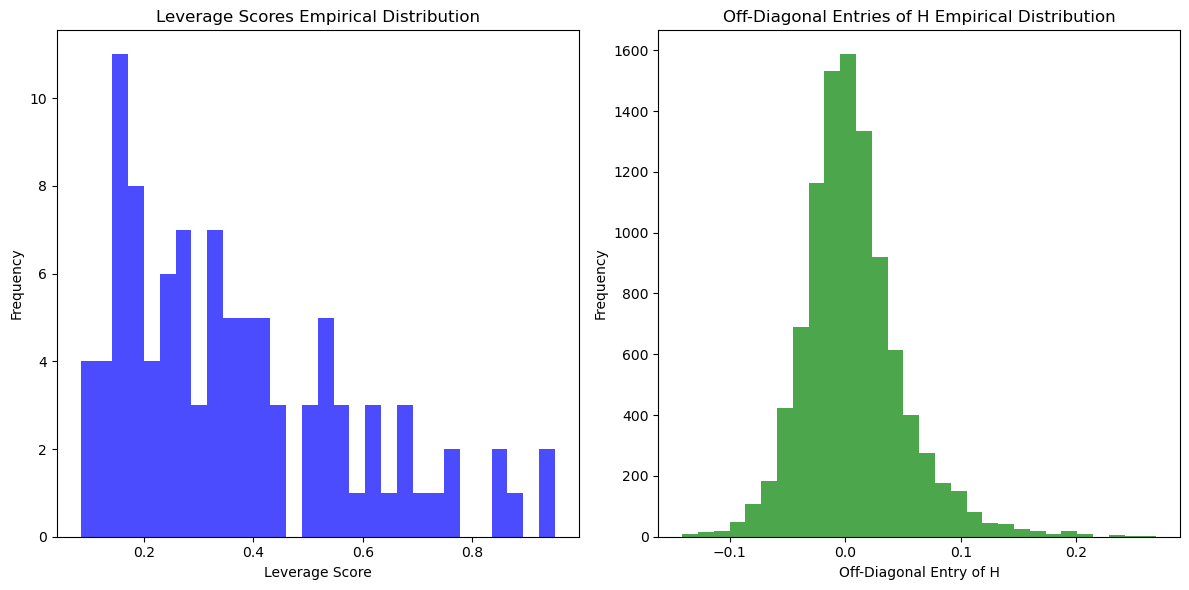

Top 7 Influential Data Points Estimate: [62 16 53 79 18 60 65]


In [19]:
X, y = datasets.fetch_california_housing(return_X_y=True)

X_interact = X.copy()

for i in range(2):
	# Add features of interacting terms between the original features
	poly = PolynomialFeatures(degree=i+1, interaction_only=True, include_bias=False)
	X_interact = poly.fit_transform(X_interact)

	linear_regression(X_interact, y, 100, 4)

Dataset size: 200 samples, 20 features
Mean Squared Error: 0.0000
Best subset of size 1: (42,)
Best subset of size 2: (52, 78)
Best subset of size 3: (40, 65, 66)
Without leverage
Top 6 Influential Data Points Estimate: [82 39 55 26 97 61]
With leverage
Largest off-diagonal entry of H: 0.13652566644317732


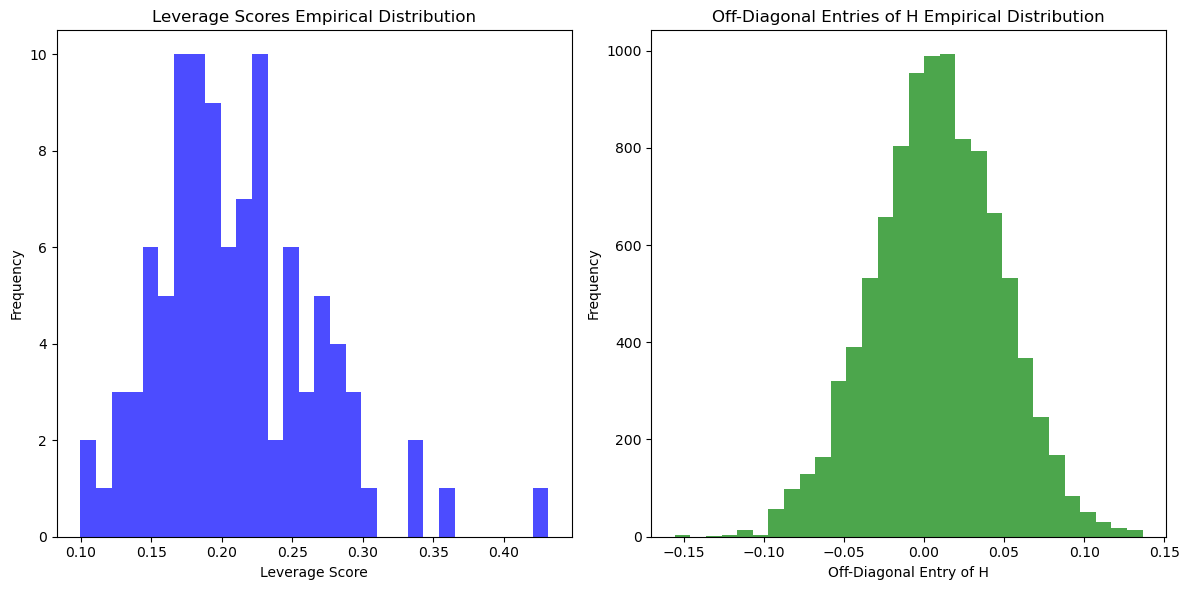

Top 6 Influential Data Points Estimate: [82 39 26 55 61 97]
Dataset size: 200 samples, 210 features
Mean Squared Error: 34183.7532
Best subset of size 1: (86,)
Best subset of size 2: (22, 86)
Best subset of size 3: (0, 22, 86)
Without leverage
Top 6 Influential Data Points Estimate: [82 45 13 23 93 27]
With leverage
Largest off-diagonal entry of H: 34.163148806998215


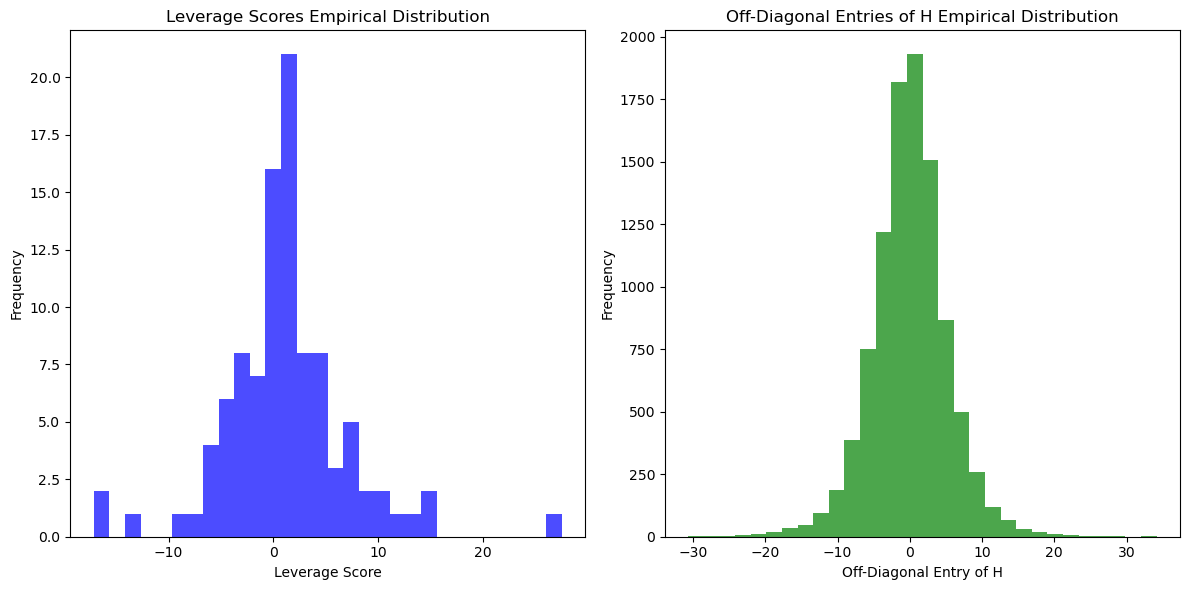

Top 6 Influential Data Points Estimate: [32 13 63 26 91 93]


In [5]:
X, y = datasets.make_regression(n_samples=200, n_features=20, n_informative=20)

X_interact = X.copy()

for i in range(2):
	# Add features of interacting terms between the original features
	poly = PolynomialFeatures(degree=i+1, interaction_only=True, include_bias=False)
	X_interact = poly.fit_transform(X_interact)

	linear_regression(X_interact, y, 100, 3)

Dataset size: 500 samples, 8 features
Mean Squared Error: 0.0040
Best subset of size 1: (53,)
Best subset of size 2: (28, 53)
Best subset of size 3: (28, 50, 53)
Best subset of size 4: (28, 50, 53, 58)
Without leverage
Top 7 Influential Data Points Estimate: [28 53 50 58 73  8 97]
With leverage
Largest off-diagonal entry of H: 0.12596845799457584


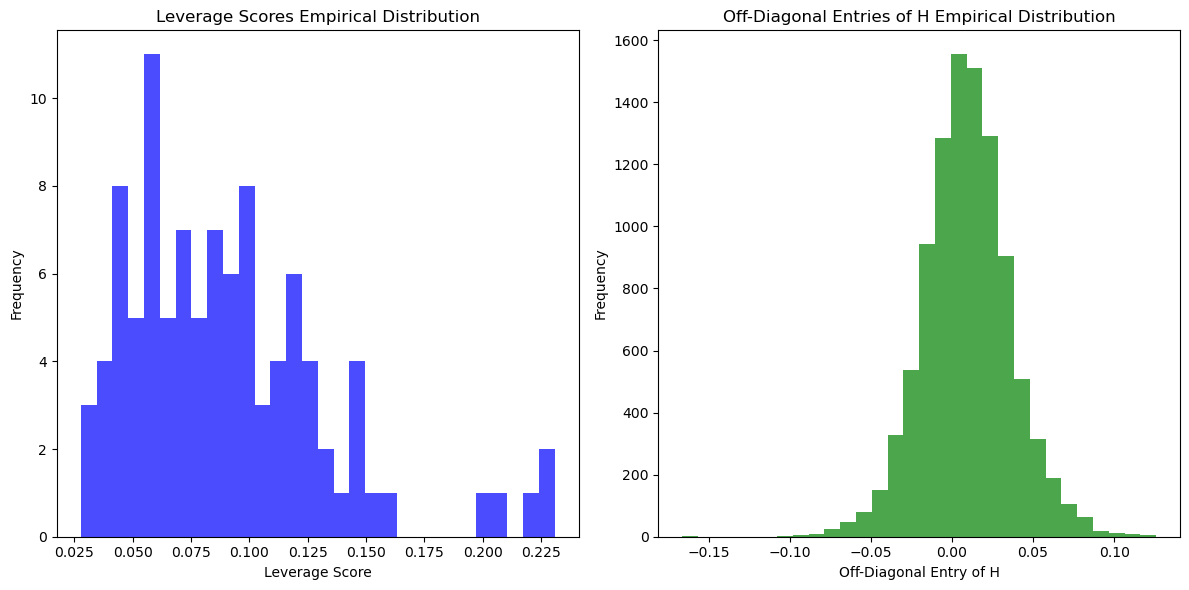

Top 7 Influential Data Points Estimate: [53 28 50 58  8 73  0]
Dataset size: 500 samples, 36 features
Mean Squared Error: 0.0062
Best subset of size 1: (31,)
Best subset of size 2: (31, 61)
Best subset of size 3: (21, 31, 50)
Best subset of size 4: (21, 31, 36, 50)
Without leverage
Top 7 Influential Data Points Estimate: [50 79 67 92 36 31 41]
With leverage
Largest off-diagonal entry of H: 0.2455651200379947


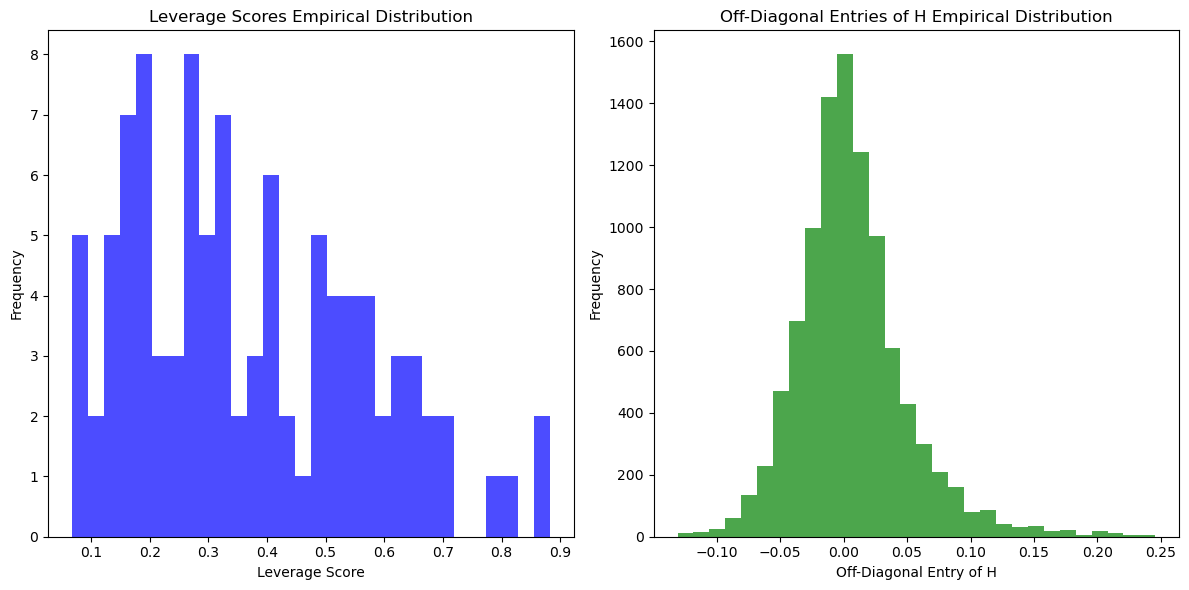

Top 7 Influential Data Points Estimate: [31 50 67 92 79 36 41]


In [22]:
# https://www.kaggle.com/datasets/mohansacharya/graduate-admissions/
admission = pd.read_csv("data/Admission_Predict_Ver1.1.csv")
y = np.array(admission['Chance of Admit '])
X = np.array(admission.drop(['Chance of Admit '], axis = 1))
X_interact = X.copy()

for i in range(2):
	# Add features of interacting terms between the original features
	poly = PolynomialFeatures(degree=i+1, interaction_only=True, include_bias=False)
	X_interact = poly.fit_transform(X_interact)

	linear_regression(X_interact, y, 100, 4)